In [15]:
%config InlineBackend.figure_format = "svg"

import sys
sys.path.append("../")

from src.networks.dn import StateType, ActionType, ObservationType, RewardType
from src.rl_algorithms.pomdp_lookahead import build_tree, pomdp_lookahead
from src.networks.qbn import QuantumBayesianNetwork as QBN
from src.networks.bn import BayesianNetwork as BN
from src.networks.ddn import DDNFactory as DDN
from src.utils import get_avg_reward_and_std
from src.networks.nodes import DiscreteNode
import matplotlib.pyplot as plt
from src.trees.tree import Tree
import numpy as np

# Creating a dynamic decision network

## Example: Tiger problem

### Constructing the Dynamic Decision Network

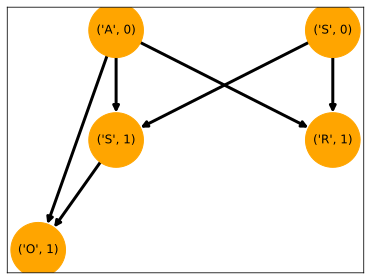

In [3]:
# Create nodes
s0 = DiscreteNode(("S", 0), node_type=StateType, value_space=[0, 1])
a0 = DiscreteNode(("A", 0), node_type=ActionType, value_space=[0, 1, 2])
s1 = DiscreteNode(("S", 1), node_type=StateType, value_space=[0, 1])
o1 = DiscreteNode(("O", 1), node_type=ObservationType, value_space=[0, 1])
r1 = DiscreteNode(("R", 1), node_type=RewardType, value_space=[-100, -1, 10])

# Settings for the POMDP
discount = 0.8
nodes = [s0, s1, o1, r1, a0]
edges = [
    (("S", 0), ("S", 1)),
    (("S", 0), ("R", 1)),
    (("A", 0), ("S", 1)), 
    (("A", 0), ("R", 1)), 
    (("A", 0), ("O", 1)), 
    (("S", 1), ("O", 1)) 
]

# Create the DDN structure
ddn = DDN(BN)(discount=discount)
ddn.add_nodes(nodes)
ddn.add_edges(edges)
ddn.draw()

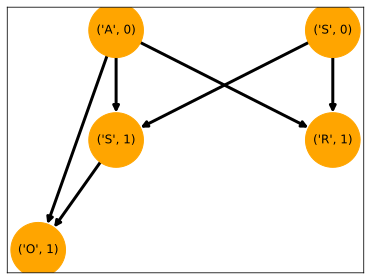

In [4]:
# Create quantum DDN
qddn = DDN(QBN)(discount=discount)
qddn.add_nodes(nodes)
qddn.add_edges(edges)
qddn.draw()

### Adding CPT data to the DDN

In [5]:
# Add data for node State 0
data = {
    ("S", 0): [0,1], 
    "Prob": [0.5,0.5]
}
ddn.add_pt(("S", 0), data)
qddn.add_pt(("S", 0), data)

# Add data for node State 1
data = {
    ("S", 0): [0,0,0,0,0,0,1,1,1,1,1,1], 
    ("A", 0): [0,0,1,1,2,2,0,0,1,1,2,2], 
    ("S", 1): [0,1,0,1,0,1,0,1,0,1,0,1], 
    "Prob": [1,0,0.5,0.5,0.5,0.5,0,1,0.5,0.5,0.5,0.5]
}
ddn.add_pt(("S", 1), data)
qddn.add_pt(("S", 1), data)

# Add data for node Evidence
data = {
    ("A", 0): [0,0,0,0,1,1,1,1,2,2,2,2], 
    ("S", 1): [0,0,1,1,0,0,1,1,0,0,1,1], 
    ("O", 1): [0,1,0,1,0,1,0,1,0,1,0,1], 
    "Prob": [0.85,0.15,0.15,0.85,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
}
ddn.add_pt(("O", 1), data)
qddn.add_pt(("O", 1), data)

# Add data for node Reward
data = {
    ("A", 0): [0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2], 
    ("S", 0): [0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1], 
    ("R", 1): [-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10,-100,-1,10], 
    "Prob": [0.05,0.9,0.05,0.05,0.9,0.05,0.9,0.05,0.05,0.05,0.05,0.9,0.05,0.05,0.9,0.9,0.05,0.05]
}
ddn.add_pt(("R", 1), data)
qddn.add_pt(("R", 1), data)

# Initialize ddn
ddn.initialize()
qddn.initialize()

### Robot search problem

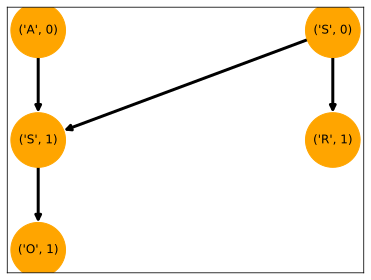

In [6]:
# Create nodes
s0 = DiscreteNode(("S", 0), node_type=StateType, value_space=[0,1,2,3])
a0 = DiscreteNode(("A", 0), node_type=ActionType, value_space=[0,1])
s1 = DiscreteNode(("S", 1), node_type=StateType, value_space=[0,1,2,3])
o1 = DiscreteNode(("O", 1), node_type=ObservationType, value_space=[0,1])
r1 = DiscreteNode(("R", 1), node_type=RewardType, value_space=[0,1])

# Settings for the POMDP
discount = 0.8
nodes = [s0, s1, o1, r1, a0]
edges = [
    (("S", 0), ("S", 1)),
    (("S", 0), ("R", 1)), 
    (("A", 0), ("S", 1)),
    (("S", 1), ("O", 1))
]

# Create the DDN structure
robot_ddn = DDN(BN)(discount=discount)
robot_ddn.add_nodes(nodes)
robot_ddn.add_edges(edges)
robot_ddn.draw()

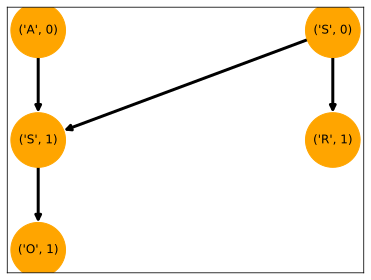

In [7]:
# Create quantum DDN structure
robot_qddn = DDN(QBN)(discount=discount)
robot_qddn.add_nodes(nodes)
robot_qddn.add_edges(edges)
robot_qddn.draw()

In [8]:
# Add data for node State 0
data = {
    ("S", 0): [0,1,2,3], 
    "Prob": [0.25,0.25,0.25,0.25]
}
robot_ddn.add_pt(("S", 0), data)
robot_qddn.add_pt(("S", 0), data)

# Add data for node State 1
data = {
    ("S", 0): [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3], 
    ("A", 0): [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1], 
    ("S", 1): [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3], 
    "Prob": [0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1/3,1/3,0,1/3,1/3,1/3,0,1/3,0,0,1,0,1,0,0,0]
}
robot_ddn.add_pt(("S", 1), data)
robot_qddn.add_pt(("S", 1), data)

# Add data for node Evidence
data = { 
    ("S", 1): [0,0,1,1,2,2,3,3], 
    ("O", 1): [0,1,0,1,0,1,0,1], 
    "Prob": [0.7,0.3,0.7,0.3,0.3,0.7,0.7,0.3]
}
robot_ddn.add_pt(("O", 1), data)
robot_qddn.add_pt(("O", 1), data)

# Add data for node Reward
data = { 
    ("S", 0): [0,0,1,1,2,2,3,3], 
    ("R", 1): [0,1,0,1,0,1,0,1], 
    "Prob": [0.8,0.2,0.8,0.2,0.2,0.8,0.8,0.2]
}
robot_ddn.add_pt(("R", 1), data)
robot_qddn.add_pt(("R", 1), data)

# Initialize ddn
robot_ddn.initialize()
robot_qddn.initialize()

### Calculating best action

In [9]:
# Build the lookahead tree
horizon = 2
action_space = ddn.get_space(ddn.action_type)
observation_space = ddn.get_space(ddn.observation_type)
tree = build_tree({}, action_space, observation_space, horizon)

In [10]:
def get_metrics(ddn, qddn, tree, classical_samples, quantum_samples, reward_samples, time, verbose=True):
    # Calculate metrics for the time-steps
    c_avg_r, c_std = [], []
    q_avg_r, q_std = [], []

    for t in range(time):

        # Classical results
        actions = pomdp_lookahead(ddn, tree, classical_samples)
        avg, std = get_avg_reward_and_std(ddn, ("R", 1), {**actions, **ddn.get_belief_state()}, reward_samples)
        observations = ddn.sample_observation(actions)
        ddn.belief_update(actions, observations, classical_samples)

        # Append results
        c_avg_r.append(avg)
        c_std.append(std)

        # Print info
        if verbose:
            print(f"\nClassical | Time-step: {t} | Exp Reward: {avg:.3f} | Std: {std:.3f}")

        # Quantum results
        actions = pomdp_lookahead(qddn, tree, quantum_samples)
        avg, std = get_avg_reward_and_std(ddn, ("R", 1), {**actions, **qddn.get_belief_state()}, reward_samples)
        observations = ddn.sample_observation(actions)
        qddn.belief_update(actions, observations, quantum_samples)

        # Append results
        q_avg_r.append(avg)
        q_std.append(std)

        # Print info
        if verbose:
            print(f"Quantum | Time-step: {t} | Exp Reward: {avg:.3f} | Std: {std:.3f}")
        
    c_avg_r, c_std = np.array(c_avg_r), np.array(c_std)
    q_avg_r, q_std = np.array(q_avg_r), np.array(q_std)
    
    return c_avg_r, c_std, q_avg_r, q_std

In [11]:
# Hyperparameters for obtaining results
time = 100
reward_samples = 1000
classical_samples = 10
quantum_samples = int(np.ceil(classical_samples**2))

In [ ]:
# Get metrics
c_avg_r, c_std, q_avg_r, q_std = get_metrics(ddn, qddn, tree, classical_samples, quantum_samples, reward_samples, time)

# Get cummulative rewards and standard deviations
c_cum_r, q_cum_r = np.cumsum(c_avg_r), np.cumsum(q_avg_r)
c_cum_std, q_cum_std = np.sqrt(np.cumsum(np.array(c_std)**2)), np.sqrt(np.cumsum(np.array(q_std)**2))


Classical | Time-step: 0 | Exp Reward: -5.532 | Std: 22.023
Quantum | Time-step: 0 | Exp Reward: -5.070 | Std: 21.225

Classical | Time-step: 1 | Exp Reward: -4.718 | Std: 20.336
Quantum | Time-step: 1 | Exp Reward: -5.015 | Std: 21.250

Classical | Time-step: 2 | Exp Reward: 3.598 | Std: 24.849
Quantum | Time-step: 2 | Exp Reward: -5.961 | Std: 22.798

Classical | Time-step: 3 | Exp Reward: -5.565 | Std: 22.008
Quantum | Time-step: 3 | Exp Reward: 5.512 | Std: 20.525

Classical | Time-step: 4 | Exp Reward: -5.587 | Std: 21.749
Quantum | Time-step: 4 | Exp Reward: -6.038 | Std: 23.001

Classical | Time-step: 5 | Exp Reward: 1.068 | Std: 29.275
Quantum | Time-step: 5 | Exp Reward: -5.268 | Std: 22.141

Classical | Time-step: 6 | Exp Reward: -5.433 | Std: 21.819
Quantum | Time-step: 6 | Exp Reward: -4.982 | Std: 21.007

Classical | Time-step: 7 | Exp Reward: 4.621 | Std: 22.570
Quantum | Time-step: 7 | Exp Reward: -4.707 | Std: 20.341

Classical | Time-step: 8 | Exp Reward: -7.358 | Std

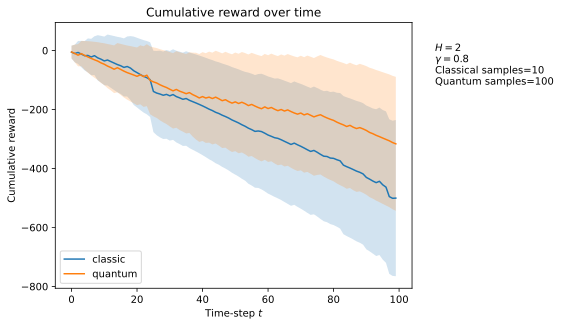

In [13]:
# Parameters for the plot
textstr = f"$H = {horizon}$"
textstr += f"\n$\gamma={discount}$"
textstr += f"\nClassical samples={classical_samples}"
textstr += f"\nQuantum samples={quantum_samples}"
# figname = input("What do you want to name your figure: ")
figname = "TigerProblemH2"

# Making the plot
plt.title("Cumulative reward over time")
plt.xlabel("Time-step $t$")
plt.ylabel("Cumulative reward")
plt.plot(range(time), c_cum_r, label="classic")
plt.fill_between(range(time), c_cum_r-c_cum_std, c_cum_r+c_cum_std, alpha=0.2)
plt.plot(range(time), q_cum_r, label="quantum")
plt.fill_between(range(time), q_cum_r-q_cum_std, q_cum_r+q_cum_std, alpha=0.2)
plt.gcf().text(0.95, 0.7, textstr, fontsize=10)
plt.legend()
# plt.savefig(f"../plots/{figname}.png", dpi=250, bbox_inches="tight")
plt.show()

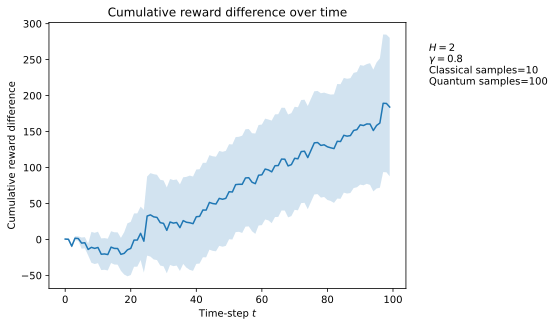

In [14]:
# Calculate cumulative difference avg and std
cum_diff_avg, cum_diff_std = q_cum_r - c_cum_r, np.sqrt(np.cumsum((q_std - c_std)**2))

# Plot the differences
plt.title("Cumulative reward difference over time")
plt.xlabel("Time-step $t$")
plt.ylabel("Cumulative reward difference")
plt.plot(range(time), cum_diff_avg)
plt.fill_between(range(time), cum_diff_avg-cum_diff_std, cum_diff_avg+cum_diff_std, alpha=0.2)
plt.gcf().text(0.95, 0.7, textstr, fontsize=10)
# plt.savefig(f"../plots/{figname}Difference.png", dpi=250, bbox_inches="tight")
plt.show()